# Civic Hacking & Urban Informatics: Mapping Data with GeoPandas

This jupyter notebook goes along with the featured Thunder Talk (https://www.pyohio.org/2020/events/talks/civic-hacking-urban-informatics-mapping-data-with-geopandas) at PyOhio 2020. If you have any questions while reading through this notebook please reach out to me through my email on my GitHub (@Katelyn98 - https://github.com/katelyn98)

### Finding Civic Data
This is one of the most imporant parts of this project as the data fuels what information is revealed. 

When you are choosing your dataset in the realm of civic hacking & urban informatics, try to look at datasets released by local organizations, city officals, or other government-related entities. 
### "The goal is to turn data into information, and information into insight" ~ Carly Fiorina
The data used in this project comes from the following locations:
Location/Quantity of Healthy Ride Bikes: https://data.wprdc.org/dataset/healthyride-stations/resource/7debf75a-1fec-4ca8-9a49-c743104b8b1a

Poor Housing Conditions in Allegheny County: https://data.wprdc.org/dataset/allegheny-county-poor-condition-residential-parcel-rates

Pittsburgh Neighborhoods: http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/dbd133a206cc4a3aa915cb28baa60fd4_0

2010 Allegheny County Census Tracts: http://pghgis-pittsburghpa.opendata.arcgis.com/datasets/e1894e5ab8ea4889923efd810b13f760_0

## Importing Libraries & Loading in Data
### Libraries Needed: 
Pandas, GeoPandas, and Shapely
### Data Types Needed: 
You will need at least one dataset that is .shp (also known as a shapefile). Shapefiles contain data such as points, lines, and polygons that can represent features such as elevation, city borders, bus stop locations, etc. 

Sometimes it is the case where your shape file also has the categorical or quantitative data that you want to map. Other times, you will need to find another dataset containing the data you want to associate with your spatial data. It is also helpful to find datasets that are not shapefiles, but have coordinates (longtitude and latitude). I will walk through how to turn a regular CSV into a Shapefile in this tutorial.
### DataFrames vs GeoDataFrames
It is important to take note that I am using GeoPandas to turn the Shapefiles into a GeoDataFrame. For more information on how these work, visit the documentation here: https://geopandas.org/data_structures.html

In [7]:
#importing libraries needed
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
#Load in the CSV Bike Station Location Data from Quarter 2 in 2020
HR_df = pd.read_csv('HRS2020Q2.csv')

#Load in the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')

#Load in the Poor Housing Conditions
poorHouseCon = gpd.read_file('poorhousingcondition/Poor_Housing_Condition.shp')

### Cleaning and Checking the Data

If you have a dataset with only Latitude and Longitude fields, you will want to make sure the data points will map correctly. You can check this by plotting the Pandas Dataframe. You can see below there is an outlier - this is an error in the data for having a negative latitude instead of a positive latitude.

In [10]:
#Print out the beginning of the dataframe to understand the fields available
#fixing wrong negative value for Latitude
HR_df.loc[HR_df["Latitude"] == HR_df["Latitude"].min()]
HR_df.at[80, 'Latitude'] = 40.467715
HR_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


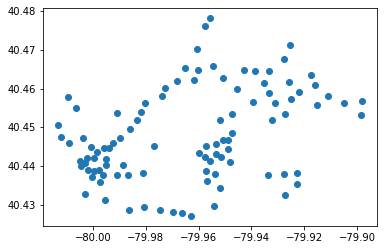

In [11]:
plt.scatter(HR_df['Longitude'], HR_df['Latitude'])
plt.show()

Checking the dataframes that we loaded in to make sure they are good, too.

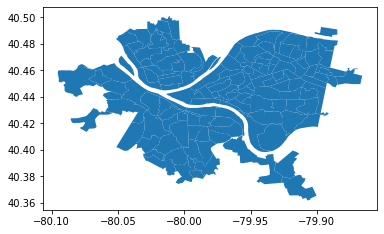

In [12]:
cenTract.plot()

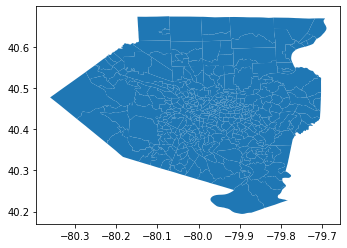

In [13]:
poorHouseCon.plot()

### Prepping the Pandas DataFrame to be turned into a GeoDataFrame

To do this, we need to take every station's latitude and longitude coordinates in the HealthyRide Pandas DataFrame and create a point. This will give us a GeoSeries that we can use to make our GeoDataFrame. You may need to set the coordinate system to be your local coordinate system. This can be researched more if the one I use does not work for you.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


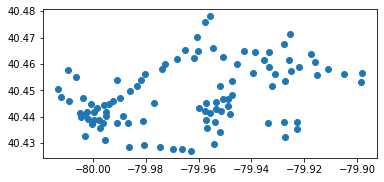

In [15]:
geometry = [Point(xy) for xy in zip(HR_df.Longitude, HR_df.Latitude)]
crs = {'init' :'epsg:4326'}
geobikes = gpd.GeoDataFrame(HR_df, crs=crs, geometry=geometry)
geobikes.plot()

### Stripping Data from the GeoDataFrames 
Next we need to take our base map which is the census tracts and shade each census tract polygon based on the percentage of poor housing. The Poor housing conditions map was for all of Allegheny county and I only wanted Pittsburgh, so I just stripped the census tracts and poor housing data from that map and merged it into the Pittsburgh Census Tracts Shapefile I had. Refer to my jupyter notebooks for more on how I did this.

In [16]:
#get only the poor housing condition rate to join to the CensusTract data frame
poorCond_data = pd.DataFrame(poorHouseCon['PPoorCon'])
poorCond_data = poorCond_data.join(poorHouseCon['TRACTCE'])
poorCond_data = poorCond_data.rename(columns={'TRACTCE': 'tractce10'})
cenTract = cenTract.merge(poorCond_data, on="tractce10")

### Plot the overlays and the map

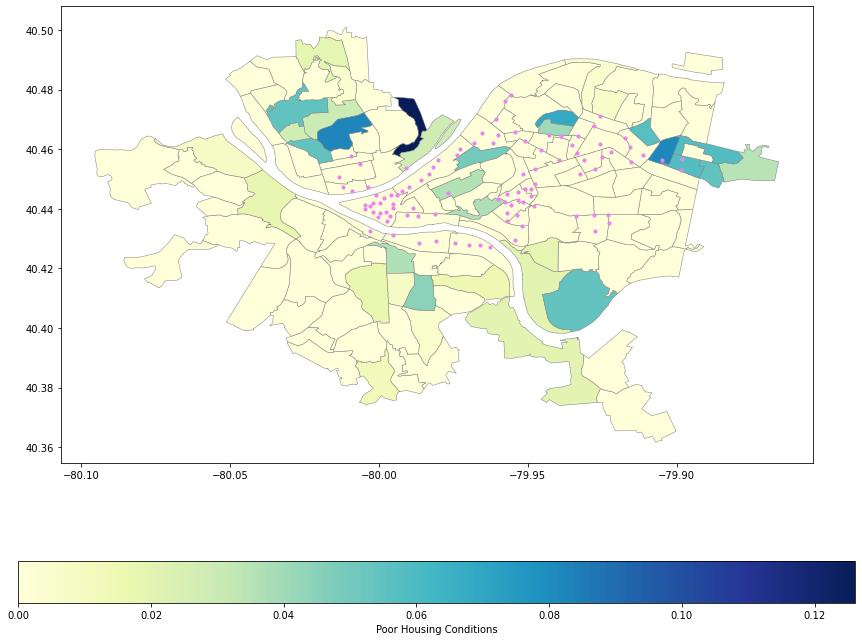

In [17]:
#plotting the poor housing condition data on the pittsburgh neighborhood map (data from 2016)
ax = cenTract.plot(column="PPoorCon", cmap='YlGnBu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "horizontal"})
#now adding the bike station location data on top of this map as an overlay
result = geobikes.plot(ax = ax, color="Violet", markersize=10);